<a href="https://colab.research.google.com/github/Nivratti/100-Days-Of-ML-Code/blob/master/Text_sentiment_analysis_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text sentiment analysis on Amazon Reviews

# Connect Google Colab with Google Drive

In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## prevent-google-colab-from-disconnecting

Google Colab notebooks have an idle timeout of 90 minutes and absolute timeout of 12 hours. This means, if user does not interact with his Google Colab notebook for more than 90 minutes, its instance is automatically terminated. Also, maximum lifetime of a Colab instance is 12 hours.

Solution:

Set a javascript interval to click on the connect button every 60 seconds. Open developer-settings (in your web-browser) with Ctrl+Shift+I then click on console tab and type this on the console prompt. (for mac press Option+Command+I)

inser below code on console

```
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton, 1000);
```




# Execution Time

In [0]:
!pip install ipython-autotime

%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=2aaf9c2600d966b8b0f9794a752e6cf460c36665b6d40f3dae47b12eec0afe0b
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


# Tensorflow with GPU -- For faster training

Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

Navigate to Edit→Notebook Settings
select GPU from the Hardware Accelerator drop-down
Next, we'll confirm that we can connect to the GPU with tensorflow:

In [0]:
%tensorflow_version 1.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow 1.x selected.
Found GPU at: /device:GPU:0
time: 6.74 s


# Global vars

In [0]:
import os

# project folder on rive containing dataset, trained model and other files
DRIVE_PROJECT_BASE_DIR = "/content/gdrive/My Drive/deep_learning/text_sentiment_analysis/"

BASE_DATASET_DIR = os.path.join(
    DRIVE_PROJECT_BASE_DIR , "dataset"
)

input_zipfile = os.path.join(
    BASE_DATASET_DIR , "amazonreviews.zip"
)

time: 4.64 ms


# Load Packages

In [0]:
import matplotlib.pyplot as plt
from tensorflow.python.keras import models, layers, optimizers
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
import bz2
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import re
import numpy as np
%matplotlib inline

time: 417 ms


# Data preparation

## Unzip zip file

In [0]:
!unzip "$input_zipfile"

Archive:  /content/gdrive/My Drive/deep_learning/text_sentiment_analysis/dataset/amazonreviews.zip
  inflating: test.ft.txt.bz2         
  inflating: train.ft.txt.bz2        
time: 15.7 s


## Reading the text

The text is held in a compressed format. Luckily, we can still read it line by line. The first word gives the label, so we have to convert that into a number and then take the rest to be the comment.

In [0]:
def get_labels_and_texts(file):
    labels = []
    texts = []
    for line in bz2.BZ2File(file):
        x = line.decode("utf-8")
        labels.append(int(x[9]) - 1)
        texts.append(x[10:].strip())
    return np.array(labels), texts

train_labels, train_texts = get_labels_and_texts('train.ft.txt.bz2')
test_labels, test_texts   = get_labels_and_texts('test.ft.txt.bz2')

time: 1min 38s


## View data shape

In [0]:
# Print shapes
print("Shape of train_labels: {}".format(train_labels.shape))
print("length of train_texts: {}".format(len(train_texts)))

print("Shape of test_labels: {}".format(test_labels.shape))
print("length of test_texts: {}".format(len(test_texts)))

Shape of train_labels: (3600000,)
length of train_texts: 3600000
Shape of test_labels: (400000,)
length of test_texts: 400000
time: 2.41 ms


# Text Preprocessing

The first thing I'm going to do to process the text is to lowercase everything and then remove non-word characters. I replace these with spaces since most are going to be punctuation. Then I'm going to just remove any other characters (like letters with accents). It could be better to replace some of these with regular ascii characters but I'm just going to ignore that here. It also turns out if you look at the counts of the different characters that there are very few unusual characters in this corpus.

In [0]:
import re
NON_ALPHANUM = re.compile(r'[\W]')
NON_ASCII = re.compile(r'[^a-z0-1\s]')
def normalize_texts(texts):
    normalized_texts = []
    for text in texts:
        lower = text.lower()
        no_punctuation = NON_ALPHANUM.sub(r' ', lower)
        no_non_ascii = NON_ASCII.sub(r'', no_punctuation)
        normalized_texts.append(no_non_ascii)
    return normalized_texts
        
train_texts = normalize_texts(train_texts)
test_texts = normalize_texts(test_texts)

time: 1min 38s


# Train/Validation Split
Now I'm going to set aside 20% of the training set for validation.

In [0]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, random_state=57643892, test_size=0.2
  )

time: 1.93 s


In [0]:
print("Shape of train_labels: {}".format(train_labels.shape))
print("length of train_texts: {}".format(len(train_texts)))

print("Shape of val_labels: {}".format(val_labels.shape))
print("length of val_texts: {}".format(len(val_texts)))

Shape of train_labels: (2880000,)
length of train_texts: 2880000
Shape of val_labels: (720000,)
length of val_texts: 720000
time: 196 ms


viewing top 5 labels and first training text.

In [0]:
print(train_labels[:5])
print(train_texts[:1])

[1 0 1 0 1]
['don t miss it   i don t know if i ve ever been treated to such a full  rich  endearing story in so few words  only a couple hundred pages   and yet i felt as if i were visiting old friends for a long stay  i enjoyed this book immensely  but then  i m rapidly approaching  miss el s  age  so maybe that s why    ']
time: 1.74 ms


# Tokenization

Now I will just run a Tokenizer using the top 12000 words as features.

In [0]:
MAX_FEATURES = 12000
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(train_texts)

train_texts = tokenizer.texts_to_sequences(train_texts)
val_texts = tokenizer.texts_to_sequences(val_texts)
test_texts = tokenizer.texts_to_sequences(test_texts)


time: 5min 33s


# Padding Sequences
In order to use batches effectively, I'm going to need to take my sequences and turn them into sequences of the same length. I'm just going to make everything here the length of the longest sentence in the training set. I'm not dealing with this here, but it may be advantageous to have variable lengths so that each batch contains sentences of similar lengths. This might help mitigate issues that arise from having too many padded elements in a sequence.


In [0]:
MAX_LENGTH = max(len(train_ex) for train_ex in train_texts)

train_texts = pad_sequences(train_texts, maxlen=MAX_LENGTH)
val_texts = pad_sequences(val_texts, maxlen=MAX_LENGTH)
test_texts = pad_sequences(test_texts, maxlen=MAX_LENGTH)

time: 39.2 s


# Save Tokenizer

In [0]:
import pickle

# saving
tokenizer_info = {
    "tokenizer"   : tokenizer,
    "MAX_LENGTH"  : MAX_LENGTH,
    "MAX_FEATURES": MAX_FEATURES,
}
with open('tokenizer_info.pickle', 'wb') as handle:
    pickle.dump(tokenizer_info, handle, protocol=pickle.HIGHEST_PROTOCOL)

time: 928 ms


In [0]:
# make some space
del tokenizer

import gc

print(f"total objects in memory --{gc.get_count()}")

# collecting memory
gc.collect()
print(f"After garbage collecor- objects in memory --{gc.get_count()}")

total objects in memory --(210, 2, 26)
After garbage collecor- objects in memory --(25, 0, 0)
time: 200 ms


# labels info

In [0]:
labels_dict = {
    "negative": 0,
    "positive": 1,
}
num_classes = len(labels_dict.items())
print(f"num_classes : {num_classes}")

num_classes : 2
time: 1.96 ms


# convert to categorical data

In [0]:
from keras.utils import to_categorical

train_y = to_categorical(train_labels, num_classes=num_classes, dtype='float32')
test_y = to_categorical(test_labels, num_classes=num_classes, dtype='float32')
val_y = to_categorical(val_labels, num_classes=num_classes, dtype='float32')

# Print shapes
print("Shape of train_y: {}".format(train_y.shape))
print("Shape of test_y: {}".format(test_y.shape))
print("Shape of val_y: {}".format(val_y.shape))

Shape of train_y: (2880000, 2)
Shape of test_y: (400000, 2)
Shape of val_y: (720000, 2)
time: 154 ms


Using TensorFlow backend.


view single record

In [0]:
print(train_y[0])

[0. 1.]
time: 2.19 ms


# Deep learning Models

In [0]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,GRU,LSTM,Embedding, CuDNNLSTM, CuDNNGRU
from keras.optimizers import Adam
from keras.layers import SpatialDropout1D,Dropout,Bidirectional,Conv1D,GlobalMaxPooling1D,MaxPooling1D,Flatten
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D

time: 6.34 ms


## Utilities

### Plotting accuracy and loss graph

In [0]:
import matplotlib.pyplot as plt

def plot_accuracy_loss(history):
  axes = plt.axes()
  axes.set_ylim([0, 1])

  # Plot training & validation accuracy values
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  axes = plt.axes()
  # axes.set_ylim([0, 1])
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

time: 8.82 ms


## LSTM

In [0]:
embed_dim = 64

model_LSTM = Sequential()
model_LSTM.add(Embedding(MAX_FEATURES, embed_dim, input_length=MAX_LENGTH, mask_zero=True))
model_LSTM.add(CuDNNLSTM(64,dropout=0.4,return_sequences=True))
model_LSTM.add(CuDNNLSTM(32,dropout=0.5,return_sequences=False))
model_LSTM.add(Dense(num_classes, activation='softmax'))
model_LSTM.compile(loss = 'categorical_crossentropy', optimizer=Adam(lr = 0.001), metrics = ['accuracy'])
model_LSTM.summary()

### Callbacks

In [0]:
# Adding the callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_path = "lstm_model.best.hdf5"

# use early stopping to optimally terminate training through callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2) # patience=3)

# save best model automatically
mc = ModelCheckpoint(
    checkpoint_path, monitor='val_loss', 
    mode='min', verbose=1, save_best_only=True
)
cb_list = [es,mc]

time: 6.34 ms


### Train

In [0]:
# Train model
epochs = 25
batch_size = 2048 # 64 # use more if gpu available - for faster processing 
history = model_LSTM.fit(
    train_texts, train_y, 
    validation_data=(val_texts, val_y), 
    epochs=epochs, 
    batch_size=batch_size, 
    verbose=1, shuffle=True,
    callbacks=cb_list,
)


Train on 2880000 samples, validate on 720000 samples
Epoch 1/2
2880000/2880000 [==============================] - 1778s 618us/step - loss: 0.2177 - accuracy: 0.9133 - val_loss: 0.1643 - val_accuracy: 0.9372
Epoch 2/2
2880000/2880000 [==============================] - 1796s 624us/step - loss: 0.1630 - accuracy: 0.9383 - val_loss: 0.1551 - val_accuracy: 0.9421
time: 59min 41s


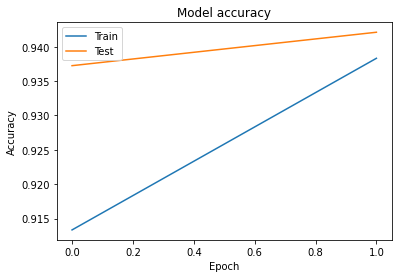

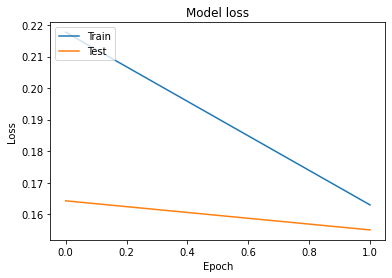

time: 438 ms


In [0]:
plot_accuracy_loss(history)

In [0]:
# preds = model_LSTM.predict(test_texts)

# print('Accuracy score: {:0.4}'.format(accuracy_score(test_labels, 1 * (preds > 0.5))))
# print('F1 score: {:0.4}'.format(f1_score(test_labels, 1 * (preds > 0.5))))
# print('ROC AUC score: {:0.4}'.format(roc_auc_score(test_labels, preds)))

time: 827 µs


## Convolutional Neural Net Model

In [0]:
# set parameters:
filters = 250
kernel_size = 3
hidden_dims = 250

model_cnn = Sequential()

model_cnn.add(Embedding(MAX_FEATURES, embed_dim, input_length=MAX_LENGTH))
model_cnn.add(Dropout(0.2))

model_cnn.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model_cnn.add(GlobalMaxPooling1D())

model_cnn.add(Dense(hidden_dims))
model_cnn.add(Dropout(0.2))
model_cnn.add(Activation('relu'))

model_cnn.add(Dense(num_classes))
model_cnn.add(Activation('softmax'))

model_cnn.compile(loss = 'categorical_crossentropy', optimizer=Adam(lr = 0.001), metrics = ['acc'])

print(model_cnn.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 255, 64)           768000    
_________________________________________________________________
dropout_14 (Dropout)         (None, 255, 64)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 253, 250)          48250     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 250)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 250)               62750     
_________________________________________________________________
dropout_15 (Dropout)         (None, 250)               0         
_________________________________________________________________
activation_13 (Activation)   (None, 250)              

### Avoid wasting resources with EarlyStopping and ModelCheckpoint in Keras

Training a neural network can take a lot of time. In some cases, especially with 
very deep architectures trained on very large data sets, it can take weeks before one’s model 
is finally trained.

Unfortunately, setting a fixed number of epochs is often a bad idea. Here’s why:

1.   When you use too few epochs, your model will remain underfit. What I mean is that its predictive power can still be improved without a loss of generalization power (i.e., it improves without overfitting). You will end up with a model that does not perform at its maximum capability.

2.   When you use too many epochs, depending on how you configure the training process, your final model will either be optimized or it will be overfit. In both cases, you will have wasted resources. Hey, but why are those resources wasted when the final model is optimal? Simple – most likely, this optimum was found in e.g. 20% of the epochs you configured the model for. 80% of the resources you used are then wasted. Especially with highly expensive tasks in computational terms, you’ll want to avoid waste as much as you can.





In [0]:
# Adding the callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_path = "cnn_model.best.hdf5"

# use early stopping to optimally terminate training through callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2) # patience=3)

# save best model automatically
mc = ModelCheckpoint(
    checkpoint_path, monitor='val_loss', 
    mode='min', verbose=1, save_best_only=True
)
cb_list = [es,mc]

time: 4.53 ms


### Start training

In [0]:
# Train model
epochs = 25
batch_size = 2048 # 64 # use more if gpu available - for faster processing 
history = model_cnn.fit(
    train_texts, train_y,
    validation_data=(val_texts, val_y), 
    epochs=epochs, 
    batch_size=batch_size,
    verbose=1,shuffle=True,
    callbacks=cb_list,
    
)

Train on 2880000 samples, validate on 720000 samples
Epoch 1/25
2880000/2880000 [==============================] - 349s 121us/step - loss: 0.1858 - acc: 0.9258 - val_loss: 0.1575 - val_acc: 0.9402

Epoch 00001: val_loss improved from inf to 0.15755, saving model to cnn_model.best.hdf5
Epoch 2/25
2880000/2880000 [==============================] - 349s 121us/step - loss: 0.1456 - acc: 0.9456 - val_loss: 0.1431 - val_acc: 0.9466

Epoch 00002: val_loss improved from 0.15755 to 0.14307, saving model to cnn_model.best.hdf5
Epoch 3/25
2880000/2880000 [==============================] - 349s 121us/step - loss: 0.1355 - acc: 0.9497 - val_loss: 0.1413 - val_acc: 0.9470

Epoch 00003: val_loss improved from 0.14307 to 0.14127, saving model to cnn_model.best.hdf5
Epoch 4/25
2880000/2880000 [==============================] - 348s 121us/step - loss: 0.1290 - acc: 0.9524 - val_loss: 0.1420 - val_acc: 0.9468

Epoch 00004: val_loss did not improve from 0.14127
Epoch 5/25
2880000/2880000 [================

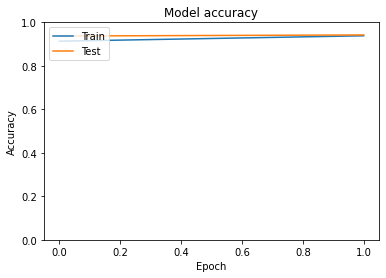

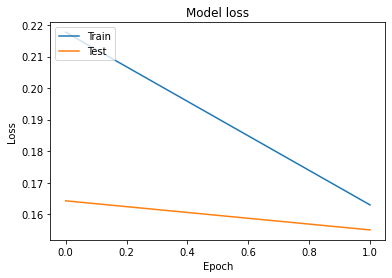

time: 416 ms


In [0]:
plot_accuracy_loss(history)

## GRU

In [0]:
def build_gru_model():
    sequences = layers.Input(shape=(MAX_LENGTH,))
    embedded = layers.Embedding(MAX_FEATURES, 64)(sequences)
    x = layers.CuDNNGRU(128, return_sequences=True)(embedded)
    x = layers.CuDNNGRU(128)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(100, activation='relu')(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=sequences, outputs=predictions)
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model
    
gru_model = build_gru_model()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
time: 307 ms


### Avoid wasting resources with EarlyStopping and ModelCheckpoint in Keras

Training a neural network can take a lot of time. In some cases, especially with 
very deep architectures trained on very large data sets, it can take weeks before one’s model 
is finally trained.

Unfortunately, setting a fixed number of epochs is often a bad idea. Here’s why:

1.   When you use too few epochs, your model will remain underfit. What I mean is that its predictive power can still be improved without a loss of generalization power (i.e., it improves without overfitting). You will end up with a model that does not perform at its maximum capability.

2.   When you use too many epochs, depending on how you configure the training process, your final model will either be optimized or it will be overfit. In both cases, you will have wasted resources. Hey, but why are those resources wasted when the final model is optimal? Simple – most likely, this optimum was found in e.g. 20% of the epochs you configured the model for. 80% of the resources you used are then wasted. Especially with highly expensive tasks in computational terms, you’ll want to avoid waste as much as you can.





In [0]:
# Adding the callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_path = "gru_model.best.hdf5"

# use early stopping to optimally terminate training through callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2) # patience=3)

# save best model automatically
mc = ModelCheckpoint(
    checkpoint_path, monitor='val_loss', 
    mode='min', verbose=1, save_best_only=True
)
cb_list = [es,mc]

time: 3.28 ms


### Train

In [0]:
epochs = 25
batch_size = 2048 # 128 # use more if gpu available - for faster processing 

history = gru_model.fit(
    train_texts, 
    train_y, 
    validation_data=(val_texts, val_y),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=cb_list,
)

Train on 2880000 samples, validate on 720000 samples
Epoch 1/25
2879488/2880000 [============================>.] - ETA: 0s - loss: 0.2411 - acc: 0.9002
Epoch 00001: val_loss improved from inf to 0.17055, saving model to gru_model.best.hdf5
2880000/2880000 [==============================] - 282s 98us/sample - loss: 0.2411 - acc: 0.9002 - val_loss: 0.1705 - val_acc: 0.9345
Epoch 2/25
2879488/2880000 [============================>.] - ETA: 0s - loss: 0.1527 - acc: 0.9421
Epoch 00002: val_loss improved from 0.17055 to 0.14378, saving model to gru_model.best.hdf5
2880000/2880000 [==============================] - 264s 92us/sample - loss: 0.1527 - acc: 0.9421 - val_loss: 0.1438 - val_acc: 0.9459
Epoch 3/25
2879488/2880000 [============================>.] - ETA: 0s - loss: 0.1346 - acc: 0.9497
Epoch 00003: val_loss improved from 0.14378 to 0.13864, saving model to gru_model.best.hdf5
2880000/2880000 [==============================] - 267s 93us/sample - loss: 0.1346 - acc: 0.9497 - val_loss: 0

time: 26min 56s


In [0]:
plot_accuracy_loss(history)

## Bidirectional-GRU

In [0]:
embed_dim = 64

def build_bidirectional_gru():
	model = Sequential()
	model.add(Embedding(MAX_FEATURES, embed_dim, input_length=MAX_LENGTH))
	model.add(SpatialDropout1D(0.25))
	model.add(Bidirectional(CuDNNGRU(64,dropout=0.4, return_sequences = True)))
	model.add(Bidirectional(CuDNNGRU(32,dropout=0.5, return_sequences = False)))
	model.add(Dense(num_classes, activation='softmax'))
	model.compile(
		loss = 'categorical_crossentropy', optimizer=Adam(lr = 0.001), 
		metrics = ['accuracy']
	)
	return model
	
bidirectional_gru_model = build_bidirectional_gru()

time: 972 ms


### Avoid wasting resources with EarlyStopping and ModelCheckpoint in Keras

Training a neural network can take a lot of time. In some cases, especially with 
very deep architectures trained on very large data sets, it can take weeks before one’s model 
is finally trained.

Unfortunately, setting a fixed number of epochs is often a bad idea. Here’s why:

1.   When you use too few epochs, your model will remain underfit. What I mean is that its predictive power can still be improved without a loss of generalization power (i.e., it improves without overfitting). You will end up with a model that does not perform at its maximum capability.

2.   When you use too many epochs, depending on how you configure the training process, your final model will either be optimized or it will be overfit. In both cases, you will have wasted resources. Hey, but why are those resources wasted when the final model is optimal? Simple – most likely, this optimum was found in e.g. 20% of the epochs you configured the model for. 80% of the resources you used are then wasted. Especially with highly expensive tasks in computational terms, you’ll want to avoid waste as much as you can.





In [0]:
# Adding the callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_path = "bidirectional_gru_model.best.hdf5"

# use early stopping to optimally terminate training through callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2) # patience=3)

# save best model automatically
mc = ModelCheckpoint(
    checkpoint_path, monitor='val_loss', 
    mode='min', verbose=1, save_best_only=True
)
cb_list = [es,mc]

time: 2.32 ms


### Train

In [30]:
epochs = 25
batch_size = 2048 # 128 # use more if gpu available - for faster processing 

history = bidirectional_gru_model.fit(
    train_texts, 
    train_y, 
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(val_texts, val_y),
    callbacks=cb_list,
)


Train on 2880000 samples, validate on 720000 samples
Epoch 1/10
2880000/2880000 [==============================] - 1688s 586us/step - loss: 0.2190 - accuracy: 0.9120 - val_loss: 0.1605 - val_accuracy: 0.9389

Epoch 00001: val_loss improved from inf to 0.16055, saving model to bidirectional_gru_model.best.hdf5
Epoch 2/10
2880000/2880000 [==============================] - 1646s 571us/step - loss: 0.1589 - accuracy: 0.9396 - val_loss: 0.1479 - val_accuracy: 0.9443

Epoch 00002: val_loss improved from 0.16055 to 0.14787, saving model to bidirectional_gru_model.best.hdf5
Epoch 3/10
2880000/2880000 [==============================] - 1581s 549us/step - loss: 0.1474 - accuracy: 0.9445 - val_loss: 0.1416 - val_accuracy: 0.9471

Epoch 00003: val_loss improved from 0.14787 to 0.14164, saving model to bidirectional_gru_model.best.hdf5
Epoch 4/10
2880000/2880000 [==============================] - 1584s 550us/step - loss: 0.1409 - accuracy: 0.9472 - val_loss: 0.1394 - val_accuracy: 0.9481

Epoch 00

KeyboardInterrupt: ignored

time: 4h 1min 11s


### Visualize

In [0]:
plot_accuracy_loss(history)

# Machine Learning

In [0]:
from sklearn.svm import LinearSVC

model = LinearSVC()
model.fit(train_texts, train_labels)
y_pred = model.predict(val_texts)

print(f"Accuracy : {accuracy_score(val_labels, y_pred)}")

conf_mat = confusion_matrix(val_labels, y_pred)
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(conf_mat, annot=True, fmt='3.0f', cmap="summer", xticklabels=classes, yticklabels=classes)
plt.title('Confusion_matrix', y=1.05, size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()